In [3]:
# virtual display for later video recording
import os
import neat
import numpy as np
import gymnasium as gym


import numpy as np 
import os
from pathlib import Path

from tqdm.auto import tqdm
from datetime import datetime as dt
import multiprocessing as mp

import bitneat

In [4]:
dir(bitneat)

['BitGenome',
 'IntGenome',
 'SoftmaxReproduction',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'animate_generations',
 'genome',
 'laststate',
 'read_genome',
 'reproduce',
 'show',
 'simulate_generations',
 'train',
 'utils',
 'visual',
 'write_genome']

In [9]:
def log_header():
    with open("log.csv", 'w') as f:
        f.write(",".join(["Timestamp", "Generation", "Best fitness", "Avg fitness"]) + '\n')

def log(data):
    data.insert(0, str(dt.now()))
    with open("log.csv", 'a') as f:
        f.write(",".join(data) + '\n')

In [11]:
help(bitneat.write_genome)

Help on function write_genome in module bitneat.utils:

write_genome(genome, filename)



In [12]:
def eval_genome(genome, config):
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    fitnesses = []

    for _ in range(1):  # Run the environment 5 times and take the average fitness
        env = gym.make("BipedalWalker-v3", hardcore=False)
        observation, _ = env.reset()
        fitness = 0.0
        max_steps = 1600

        for i in range(max_steps):
            action = net.activate(observation)
            observation, reward, done, truncated, info = env.step(action)
            fitness += reward
            if done or truncated:
                break

        fitnesses.append(fitness)
        env.close()

    return np.mean(fitnesses)

def eval_genomes(genomes, config, storage="models"):
    global gen
    best_fitness = -1e10
    most_fit = None
    avg_fitness = []
    # Get the number of CPU cores
    num_cores = mp.cpu_count()

    # Create a pool with the number of cores minus one
    pool = mp.Pool(processes=num_cores - 1)
    
    results = [pool.apply_async(eval_genome, args=(genome, config)) for _, genome in genomes]
    pool.close()  # Close the pool to prevent new tasks from being submitted

    # Create a progress bar
    pbar = tqdm(total=len(genomes), desc=f"Generation {gen:3}", unit="genome")

    for genome_id, (_, genome) in enumerate(genomes):
        fitness = results[genome_id].get()  # Retrieve the result from the worker process
        genome.fitness = fitness

        avg_fitness.append(genome.fitness)

        if genome.fitness > best_fitness:
            best_fitness = genome.fitness
            most_fit = genome

        # Update the progress bar
        pbar.set_postfix(best_fitness=f"{best_fitness:.3f}", avg_fitness=f"{np.mean(avg_fitness):.3f}")
        pbar.update(1)

    pbar.close()

    # Wait for all worker processes to finish
    for result in results:
        result.wait()

    os.makedirs(storage, exist_ok=True)
    bitneat.write_genome(most_fit, os.path.join(storage, f"genome_{gen}.pkl"))
    log([str(gen), str(best_fitness), str(np.mean(avg_fitness))])
    # log(f"Gen: {gen:3} | Best fitness: {best_fitness:.3f} | Avg fitness: {np.mean(avg_fitness):.3f}")
    gen += 1

    pool.join() 

In [13]:
# Load the NEAT configuration
config = neat.Config(
    bitneat.BitGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    'configs/config-bipedal.txt'
)


In [14]:
# Create the NEAT population
p = neat.Population(config)

# Run the NEAT algorithm for a smaller number of generations
gen = 0
log_header()
best_genome = p.run(eval_genomes, 50)

Generation  49: 100%|██████████| 200/200 [00:13<00:00, 15.28genome/s, avg_fitness=-26.046, best_fitness=22.579]


In [18]:
gen = 48
base_path = "."
genome = bitneat.read_genome(os.path.join(base_path, "models", f'genome_{gen}.pkl'))
print("Generation:", gen)
print('Fitness:', round(genome.fitness, 2))
print("Nodes, Connections:", genome.size())
print("Sum of Biases:", sum([t.bias for t in genome.nodes.values()]))
print("Weight distribution:", set([t.weight for t in genome.connections.values()]))

Generation: 48
Fitness: 22.59
Nodes, Connections: (14, 95)
Sum of Biases: 0.0
Weight distribution: {-0.0, 1.0, -1.0}


In [19]:
env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")
net = neat.nn.FeedForwardNetwork.create(genome, config)

100%|█████████▉| 1599/1601 [00:07<00:00, 202.57it/s]


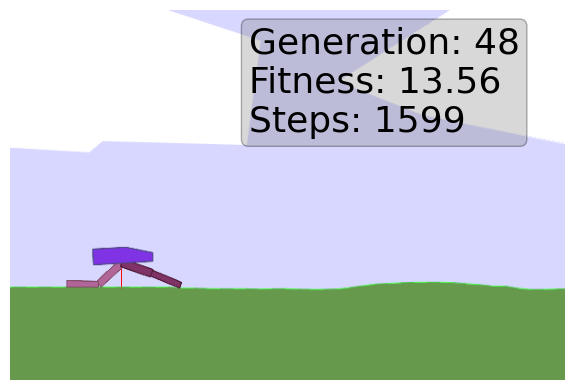

In [20]:
bitneat.laststate(net, env, frame_count=1601, gen=gen)